# <span style="color: Orange;">**Random Forest Classifier: Baseline**</span>

### **Table of Contents**

1. [Section I: Environment Setup and Configuration](#section-i-environment-setup-and-configuration)  
   Introduction to the libraries used and loading paths to dataset splits and configurations from the YAML file.

2. [Section II: Data Loading](#section-ii-data-loading)  
   Loading the raw, engineered, and main dataset splits for features and labels into memory.

3. [Section III: Baseline Model and Learning Curves](#section-iii-baseline-model-and-learning-curves)  
   Initialization of a Random Forest baseline model and plotting learning curves to diagnose overfitting and model capacity.

4. [Section IV: Cross-Validation and Hyperparameter Optimization](#section-iv-cross-validation-and-hyperparameter-optimization)  
   Utilizing stratified cross-validation for performance evaluation and randomized search for hyperparameter tuning tailored to malignant class recall.

5. [Section V: Model Evaluation with Classification Reports](#section-v-model-evaluation-with-classification-reports)  
   Generating detailed classification reports on validation and test sets to assess precision, recall, and F1-score across classes.

6. [Section VI: Feature Importance and Interpretability](#section-vi-feature-importance-and-interpretability)  
   Visualization of feature importances and SHAP value analysis, followed by selection of high-importance features to guide modeling.

7. [Section VII: Model Training and Evaluation on Combined Selected Features](#section-vii-model-training-and-evaluation-on-combined-selected-features)  
   Training and tuning a Random Forest on the combined top features followed by final evaluation on validation and test datasets.

### <span style="color: Orange;">**Section I: Environment Setup and Configuration**</span>

In this section, we begin by importing all the essential Python libraries commonly used for data analysis, visualization, and preprocessing. 
- **Pandas** and **NumPy** provide robust functionality for handling structured data and efficient numerical computations.  
- **Matplotlib** and **Seaborn** are used for visualizations, enabling us to better understand trends, patterns, and distributions within the dataset.  

Following this, we load all the **notebook-specific configurations** from an external YAML file. This configuration file stores paths for different dataset splits (training, validation, and testing) in **raw**, **engineered**, and **processed** forms, both for input features (`X`) and corresponding labels (`y`).  

By structuring the data loading process via a configuration file, we ensure flexibility and easier reproducibility across experiments.


In [1]:
# Importing all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

### <span style="color: Orange;">**Section II: Data Loading**</span>

In this section, we load the different dataset splits into memory. The Wisconsin Breast Cancer dataset has been preprocessed and stored in three different forms:  

1. **Engineered Features (`*_eng`)**  
   - These contain features that have undergone transformations such as scaling, feature engineering, or other preprocessing steps to enhance model performance.  

2. **Raw Features (`*_raw`)**  
   - The unmodified dataset, preserved in its original state to allow for baseline comparisons and exploratory analysis without preprocessing bias.  

3. **Main Split (`X_train`, `X_val`, `X_test`)**  
   - A curated version of the dataset intended as the primary set for model training, validation, and testing. This split reflects the actual datasets that will be used across modeling experiments.  

All labels (`y`) are loaded alongside their corresponding features and immediately converted into **Series objects** (via `.squeeze()`) for easier handling in downstream tasks. By separating raw, engineered, and main splits, we can compare model performance across different preprocessing strategies in a consistent and reproducible manner.


In [3]:
# Load engineered features and labels
X_train_eng = pd.read_csv(X_train_eng)
X_val_eng = pd.read_csv(X_val_eng)
X_test_eng = pd.read_csv(X_test_eng)
y_train_eng = pd.read_csv(y_train_eng).squeeze()
y_val_eng = pd.read_csv(y_val_eng).squeeze()
y_test_eng = pd.read_csv(y_test_eng).squeeze()

# Load raw features and labels
X_train_raw = pd.read_csv(X_train_raw)
X_val_raw = pd.read_csv(X_val_raw)
X_test_raw = pd.read_csv(X_test_raw)
y_train_raw = pd.read_csv(y_train_raw).squeeze()
y_val_raw = pd.read_csv(y_val_raw).squeeze()
y_test_raw = pd.read_csv(y_test_raw).squeeze()

# Load the main split as well
X_train = pd.read_csv(X_train)
X_val = pd.read_csv(X_val)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train).squeeze()
y_val = pd.read_csv(y_val).squeeze()
y_test = pd.read_csv(y_test).squeeze()

### <span style="color: Orange;">**Section III: Baseline Model and Learning Curves**</span>

To establish a solid baseline for classification performance on the Wisconsin Breast Cancer dataset, we begin by **initializing a Random Forest model** using Scikit-Learn's `RandomForestClassifier`. The hyperparameters are carefully chosen to mitigate overfitting, with constraints on tree depth, minimum samples per split and leaf, and balanced class weighting to address potential class imbalance in malignant versus benign labels.  

Next, we implement a reusable function to **plot learning curves**, allowing for a visual assessment of how model generalization behaves as the size of the training set increases. The function displays both mean scores and standard deviations for training and validation sets, supporting customizable scoring metrics—here primarily recall for the malignancy class—to align with medical application priorities.  

Finally, we adopt **StratifiedKFold cross-validation** to maintain robust class distribution across splits and plot learning curves for both **engineered and raw features**. This comparative approach highlights the impact of feature engineering on overfitting and generalization, guiding further model optimization or preprocessing efforts.


In [4]:
# Initializing a Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Initializing the model
rf_v1_eng = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    min_samples_split=12,
    min_samples_leaf=10,
    max_features='sqrt'
)

In [5]:
# Code for plotting the learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f'Training {scoring}')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label=f'Validation {scoring}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(f'{scoring}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Custom Scorer for the Recall of the malignancy class
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
recall_malignant = make_scorer(recall_score, pos_label=1)

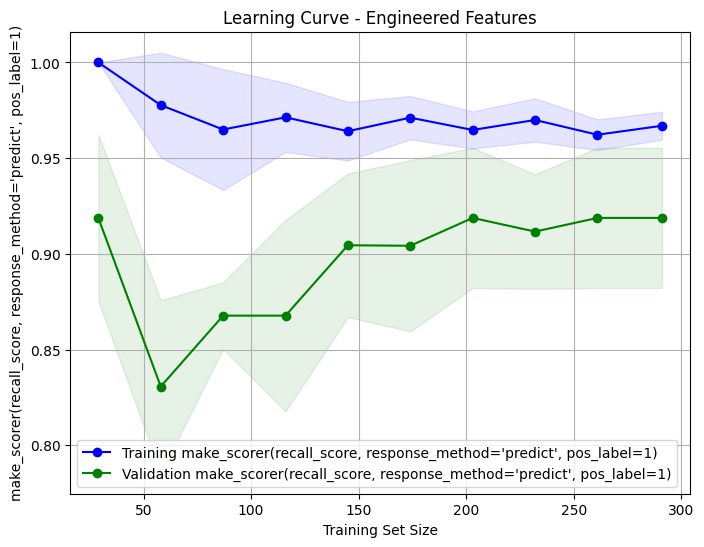

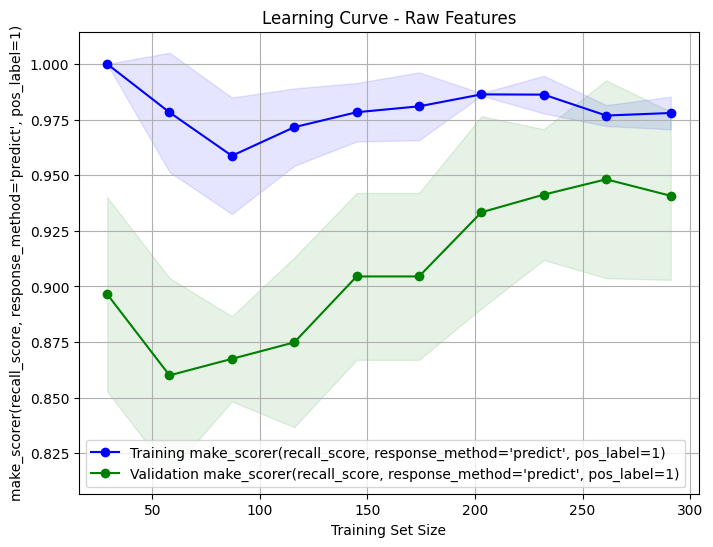

In [6]:
# Plotting the learning curves
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold instance
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Plot on engineered features
plot_learning_curve(
    rf_v1_eng, X_train_eng, y_train_eng, 
    'Learning Curve - Engineered Features', 
    cv=stratified_cv, scoring=recall_malignant
)
# Plot on raw features
plot_learning_curve(
    rf_v1_eng, X_train_raw, y_train_raw, 
    'Learning Curve - Raw Features', 
    cv=stratified_cv, scoring=recall_malignant
)

### <span style="color: Orange;">**Section IV: Cross-Validation and Hyperparameter Optimization**</span>

In this section, we implement robust **cross-validation** to estimate the real-world performance of our Random Forest classifier using multiple metrics tailored to the detection of malignant cases: recall, precision, and F1-score. By evaluating both the engineered and raw feature sets, we gain unbiased insight into how each preprocessing variant generalizes across stratified folds. Summary statistics from five-fold cross-validation highlight the trade-offs between recall, precision, and combined F1-score on both input types, ensuring that our models do not simply memorize the training data but achieve reliable predictive accuracy for cancer detection.  

We further perform an extensive **hyperparameter tuning** using `RandomizedSearchCV` across a carefully designed parameter grid, applying stratified cross-validation and optimizing for malignant recall. The best hyperparameters are selected from 50 randomized configurations for each feature set, resulting in tuned models optimized for medical relevance. This process helps validate the stability and performance of our baseline approach, while ensuring reproducibility and high recall for critical classes.  

The resulting best parameters and cross-validation scores provide actionable benchmarks and guide further experimentation or model refinement.


In [7]:
# Cross Validation for robust, unbiased estimates of your model’s real-world performance on the selected scoring metric
from sklearn.model_selection import cross_validate

# Some more scoring tailored towards malignant cases
precision_malignant = make_scorer(precision_score, pos_label=1)
f1_malignant = make_scorer(f1_score, pos_label=1)
scoring = {
    'recall_malignant': recall_malignant,
    'precision_malignant': precision_malignant,
    'f1_malignant': f1_malignant
}
# Cross-validation with multiple scoring metrics on Engineered features
cv_results_eng = cross_validate(
    rf_v1_eng, X_train_eng, y_train_eng, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

# Cross-validation with multiple scoring metrics on Raw features
cv_results_raw = cross_validate(
    rf_v1_eng, X_train_raw, y_train_raw, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

# Print results summary for Engineered Features
for metric in scoring.keys():
    scores = cv_results_eng[f'test_{metric}']
    print(f"Engineered Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

# Print results summary for Raw Features
for metric in scoring.keys():
    scores = cv_results_raw[f'test_{metric}']
    print(f"Raw Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

Engineered Features - recall_malignant: 0.919 ± 0.037
Engineered Features - precision_malignant: 0.874 ± 0.071
Engineered Features - f1_malignant: 0.894 ± 0.036
Raw Features - recall_malignant: 0.948 ± 0.044
Raw Features - precision_malignant: 0.890 ± 0.073
Raw Features - f1_malignant: 0.916 ± 0.041


In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define malignant and benign recall scorers
recall_malignant = make_scorer(recall_score, pos_label=1)
recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

# Define hyperparameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 4, 8, 12],
    'min_samples_leaf': [1, 4, 8, 12],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameter tuning for Engineered Features
random_search_eng = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',  # Select best model using malignant recall
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_eng.fit(X_train_eng, y_train_eng)
print("Best Parameters (Engineered):", random_search_eng.best_params_)

# Hyperparameter tuning for Raw Features
random_search_raw = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_raw.fit(X_train_raw, y_train_raw)
print("Best Parameters (Raw):", random_search_raw.best_params_)

# Access best estimators after tuning
best_rf_eng = random_search_eng.best_estimator_
best_rf_raw = random_search_raw.best_estimator_

# Access cv results if needed
results_eng = random_search_eng.cv_results_
results_raw = random_search_raw.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Engineered): {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 6, 'class_weight': 'balanced_subsample'}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Raw): {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 5, 'class_weight': 'balanced'}


### <span style="color: Orange;">**Section V: Model Evaluation with Classification Reports**</span>

After hyperparameter tuning and model selection, we evaluate the final Random Forest classifiers on both validation and test splits for engineered and raw feature sets.  

Using Scikit-Learn’s `classification_report`, we generate comprehensive summaries of key classification metrics—precision, recall, F1-score, and support—for each target class: **Benign** and **Malignant**. These reports provide detailed insights into model performance beyond overall accuracy, highlighting strengths and weaknesses in identifying the critical malignant cases.  

Presenting reports on both validation and test sets helps confirm that performance generalizes well and that the models have not overfit the training data. This step is crucial for reliable assessment before any deployment or further experimentation.


In [9]:
# Classification report on the Validation Splits
from sklearn.metrics import classification_report

# Predict on validation set with best estimator from engineered feature pool
y_val_pred_eng = best_rf_eng.predict(X_val_eng)
print("Classification Report - Engineered Features Validation Set")
print(classification_report(y_val_eng, y_val_pred_eng, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from engineered feature pool
y_test_pred_eng = best_rf_eng.predict(X_test_eng)
print("Classification Report - Engineered Features Test Set")
print(classification_report(y_test_eng, y_test_pred_eng, target_names=['Benign', 'Malignant']))

Classification Report - Engineered Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Engineered Features Test Set
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [10]:
# Predict on validation set with best estimator from raw feature pool
y_val_pred_raw = best_rf_raw.predict(X_val_raw)
print("Classification Report - Raw Features Validation Set")
print(classification_report(y_val_raw, y_val_pred_raw, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from raw feature pool
y_test_pred_raw = best_rf_raw.predict(X_test_raw)
print("Classification Report - Raw Features Test Set")
print(classification_report(y_test_raw, y_test_pred_raw, target_names=['Benign', 'Malignant']))

Classification Report - Raw Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Raw Features Test Set
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



### <span style="color: Orange;">**Section VI: Feature Importance and Interpretability**</span>

Understanding which features drive model decisions is critical, especially in medical applications. Here, we first plot **feature importances** from the optimized Random Forest models trained on engineered and raw feature sets. These bar plots visually rank features by their relative influence, helping identify the most predictive attributes for classification.  

To gain deeper insight into feature contributions at the instance level, we use **SHAP (SHapley Additive exPlanations)** values. SHAP summary plots display both the magnitude and direction of each feature’s impact on model output across the validation samples, providing interpretable explanations for model predictions.  

Finally, we perform a **feature selection step** by filtering features that exceed prescribed importance thresholds for engineered and raw sets. These selected features are combined into a unique set, preserving the highest importance score for any duplicates. This unified feature subset offers a refined input space for downstream modeling, balancing interpretability and predictive power.


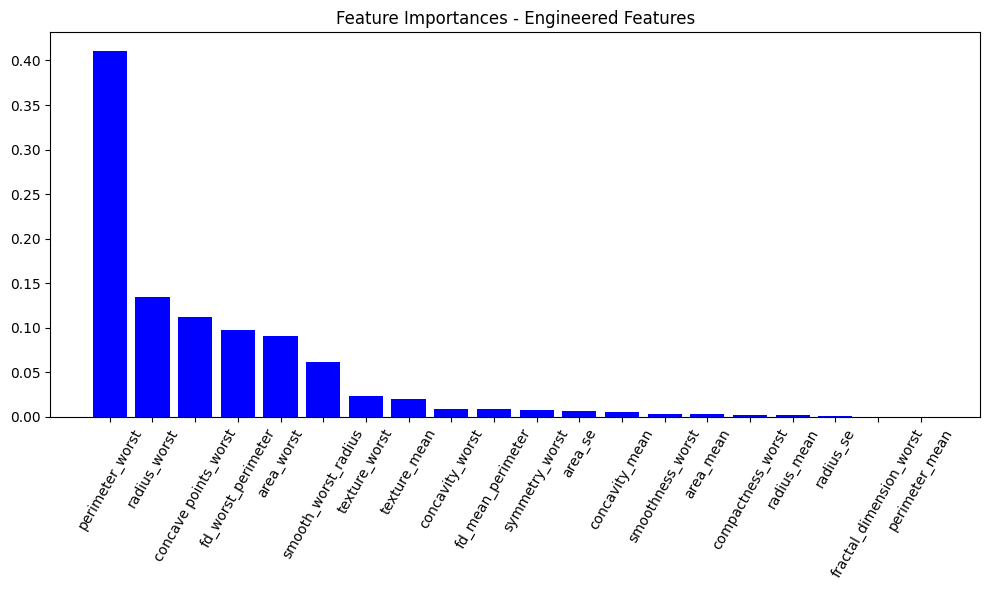

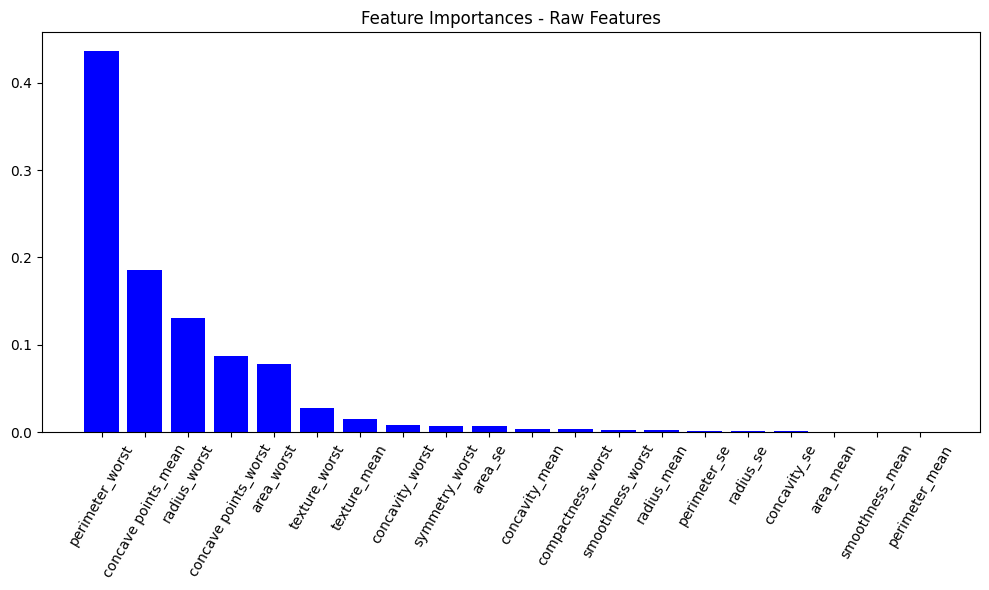

In [11]:
# Plotting the feature Importances
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], color='b', align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=60)
    plt.tight_layout()
    plt.show()

# For engineered features
plot_feature_importances(best_rf_eng, X_train_eng.columns, "Feature Importances - Engineered Features")

# For raw features
plot_feature_importances(best_rf_raw, X_train_raw.columns, "Feature Importances - Raw Features")

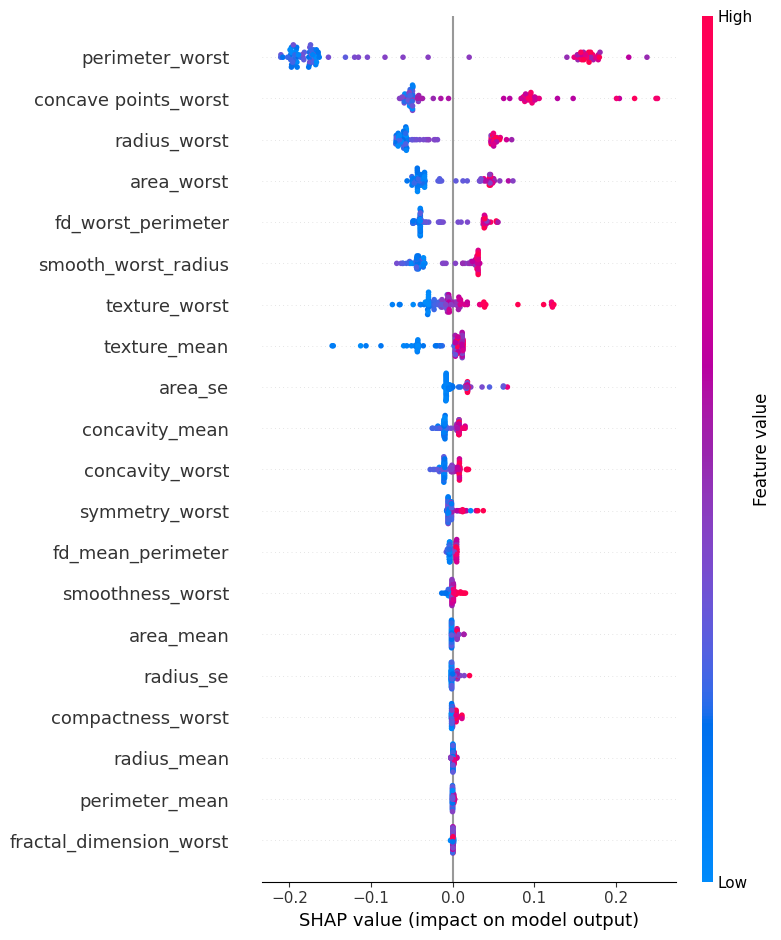

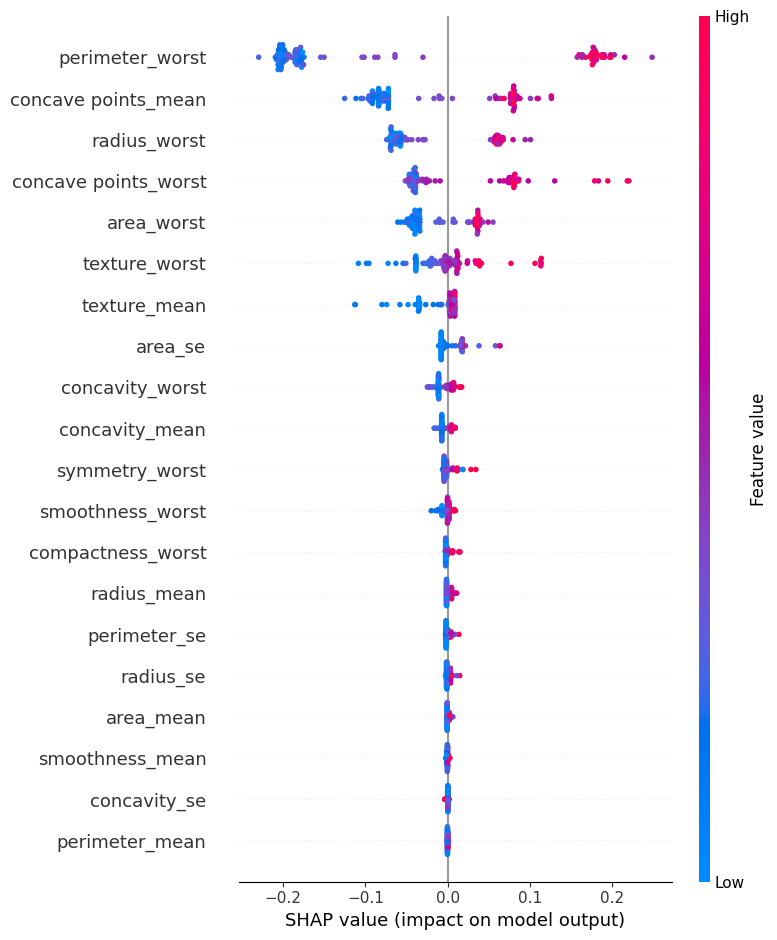

In [12]:
import shap

# Create TreeExplainer for your engineered features model
explainer_eng = shap.TreeExplainer(best_rf_eng)

# Calculate SHAP values for the validation set
shap_values_eng = explainer_eng.shap_values(X_val_eng)

# Plot SHAP summary for engineered features
shap.summary_plot(shap_values_eng[:,:,1], X_val_eng, feature_names=X_val_eng.columns, title="SHAP Summary - Engineered Features")


# Create TreeExplainer for your raw features model
explainer_raw = shap.TreeExplainer(best_rf_raw)

# Calculate SHAP values for the validation set
shap_values_raw = explainer_raw.shap_values(X_val_raw)

# Plot SHAP summary for raw features
shap.summary_plot(shap_values_raw[:,:,1], X_val_raw, feature_names=X_val_raw.columns, title="SHAP Summary - Raw Features")


In [13]:
def select_features_above_threshold(model, feature_names, threshold):
    importances = model.feature_importances_
    selected = [(feature, imp) for feature, imp in zip(feature_names, importances) if imp >= threshold]
    # Sort by importance descending
    selected_sorted = sorted(selected, key=lambda x: x[1], reverse=True)
    return selected_sorted

# Select features above threshold from engineered features
selected_eng = select_features_above_threshold(best_rf_eng, X_train_eng.columns, threshold=0.04)
print("Selected Engineered Features:", [f[0] for f in selected_eng])

# Select features above threshold from raw features
selected_raw = select_features_above_threshold(best_rf_raw, X_train_raw.columns, threshold=0.08)
print("Selected Raw Features:", [f[0] for f in selected_raw])

# Combine unique features, preserving importance (choose max importance if duplicated)
combined_dict = {}

for feature, importance in selected_eng + selected_raw:
    if feature in combined_dict:
        combined_dict[feature] = max(combined_dict[feature], importance)
    else:
        combined_dict[feature] = importance

# Sort combined features by importance descending
combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)
combined_features = [f[0] for f in combined_sorted]

print("Combined Unique Features:", len(combined_features))

Selected Engineered Features: ['perimeter_worst', 'radius_worst', 'concave points_worst', 'fd_worst_perimeter', 'area_worst', 'smooth_worst_radius']
Selected Raw Features: ['perimeter_worst', 'concave points_mean', 'radius_worst', 'concave points_worst']
Combined Unique Features: 7


### <span style="color: Orange;">**Section VII: Model Training and Evaluation on Combined Selected Features**</span>

In this final section, we leverage the curated combined feature set selected from previous importance and SHAP analyses to train a new Random Forest classifier. This streamlined feature space aims to retain the most predictive attributes while reducing model complexity and improving interpretability.  

We again perform **hyperparameter tuning using RandomizedSearchCV** with a focused parameter grid tailored to this reduced feature set, optimizing for malignant recall as the primary metric. This ensures the model prioritizes detecting malignant cases effectively while maintaining balance across classes.  

After fitting the best model, we evaluate it on validation and test splits using detailed classification reports. The results demonstrate strong performance with balanced precision, recall, and F1-scores, confirming that the combined feature approach yields a robust and efficient classifier suitable for downstream applications.

In [14]:
X_train_combined = X_train[combined_features]
X_val_combined = X_val[combined_features]
X_test_combined = X_test[combined_features]
y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

In [15]:
rf_combined = RandomForestClassifier(random_state=42, n_jobs=-1)

recall_malignant = make_scorer(recall_score, pos_label=1)
recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

# Define hyperparameter distribution to search
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_search = RandomizedSearchCV(
    estimator=rf_combined,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
# Fit on combined training data
random_search.fit(X_train_combined, y_train_combined)

# Best params and estimator
print("Best Hyperparameters:", random_search.best_params_)
best_rf_combined = random_search.best_estimator_

# Validate on validation set
y_val_pred = best_rf_combined.predict(X_val_combined)
print("Validation Classification Report:\n", classification_report(y_val_combined, y_val_pred))

# Test performance
y_test_pred = best_rf_combined.predict(X_test_combined)
print("Test Classification Report:\n", classification_report(y_test_combined, y_test_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'class_weight': 'balanced_subsample'}
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96        57
           1       0.91      0.94      0.93        34

    accuracy                           0.95        91
   macro avg       0.94      0.94      0.94        91
weighted avg       0.95      0.95      0.95        91

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

